In [1]:
import emll

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import theano
import cobra
np.random.seed(123)
pm.set_tt_rng(42)

Import the cobra model in order to obtain the reactions, internal/external metabolites for stoichiometric matrix

In [2]:
config = cobra.Configuration()
config.solver = "glpk"
model = cobra.io.load_json_model('glycolysis_to_itaconate_reduced.json')

r_compartments = [
    r.compartments if 'e' not in r.compartments else 't'
    for r in model.reactions
]

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = 't'

m_compartments = [
    m.compartment for m in model.metabolites
]

In [3]:
v_star = pd.read_csv('v_star.csv',header=None,index_col=0)[1]

In [4]:
x = pd.read_csv('Metab.csv',index_col=0).fillna(0.001)

In [5]:
v = pd.read_csv('Boundary_Flux.csv',index_col=0)

In [6]:
e = pd.read_csv('Prot.csv',index_col=0)

In [7]:
to_consider = v.columns
n_exp = len(to_consider) - 1
ref_state = 'Ylypol_F580_R2_mal_08'

In [8]:
xn = (x.T.divide(x[ref_state]) * np.log(2))
xn = xn.clip(lower=np.exp(-4), upper=np.exp(4))
en = (2 ** e).subtract(e[ref_state],0).T.fillna(0.1)
#en = e.T.divide(e[ref_state]).fillna(0.1)


In [9]:
v_star_df = pd.DataFrame(v_star).reset_index().rename(columns = {0: 'id', 1:'flux'})
v_merge = v.merge(v_star_df, left_index=True, right_on='id').set_index('id')
vn = v_merge.divide(v_merge.flux, 0).drop('flux',1).T

In [10]:
vn = vn.drop(ref_state)
xn = xn.drop(ref_state)
en = en.drop(ref_state)

In [11]:
x_inds = np.array([model.metabolites.index(met) for met in xn.columns])

In [12]:
e_inds = np.array([model.reactions.index(rxn) for rxn in en.columns])

In [13]:
v_inds = np.array([model.reactions.index(rxn) for rxn in vn.columns])

In [14]:
e_laplace_inds = []
e_zero_inds = []
for i,rxn in enumerate(model.reactions):
    if rxn.id not in en.columns:
        if ('e' not in rxn.compartments) and (len(rxn.compartments) == 1):
            e_laplace_inds += [i]
        else:
            e_zero_inds += [i]

In [15]:
e_laplace_inds = np.array(e_laplace_inds)
e_zero_inds = np.array(e_zero_inds)
e_indexer = np.hstack([e_inds, e_laplace_inds, e_zero_inds]).argsort()

In [16]:
N = cobra.util.create_stoichiometric_matrix(model)

In [17]:
Ex = emll.create_elasticity_matrix(model)
Ex = 0.1 + 0.8 * np.random.rand(*Ex.shape)

In [18]:
Ey = emll.create_Ey_matrix(model)

In [19]:
ll = emll.LinLogLeastNorm(N,Ex,Ey,v_star.values, driver = 'gelsy')

In [20]:
from emll.util import initialize_elasticity

with pm.Model() as pymc_model:
    
    #Elasticity Priors
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(
        ll.N, b = 0.05, sd=1, alpha = None,
        m_compartments=m_compartments,
        r_compartments=r_compartments
    ))
    
    Ey_t = theano.tensor.as_tensor_variable(Ey)
    
    #Protein Expression Priors
    
    e_measured = pm.Normal('log_e_measured', mu=np.log(en), sd=0.1,
                          shape = (n_exp, len(e_inds)))
    
    e_unmeasured = pm.Laplace('log_e_unmeasured', mu=0, b=0.1,
                             shape = (n_exp, len(e_laplace_inds)))
    
    log_en_t = theano.tensor.concatenate(
        [e_measured, e_unmeasured,
        theano.tensor.zeros((n_exp, len(e_zero_inds)))], axis=1)[:, e_indexer]
    
    pm.Deterministic('log_en_t', log_en_t)
    
    #External Metabolite Priors
    
    yn_t = pm.Normal('yn_t', mu=0, sd=10, shape=(n_exp, ll.ny),
                    testval=0.1 * np.random.randn(n_exp, ll.ny))
        
    #Internal Metabolite Steady State priors
    
    chi_ss, vn_ss = ll.steady_state_theano(Ex_t, Ey_t, theano.tensor.exp(log_en_t), yn_t)
    pm.Deterministic('chi_ss', chi_ss)
    
    chi_clip = theano.tensor.clip(chi_ss[:, x_inds], -1.5, 1.5)
    
    chi_obs = pm.Normal('chi_obs', mu=chi_clip, sd=0.04,
                       observed = xn.clip(lower= -1.5, upper= 1.5))

In [21]:
with pymc_model:
    RANDOM_SEED = np.random.seed(123)
    trace_prior = pm.sample_prior_predictive(samples=200, random_seed=RANDOM_SEED)


In [22]:
with pymc_model:
    advi = pm.ADVI(random_seed = RANDOM_SEED)
    tracker = pm.callbacks.Tracker(
    mean = advi.approx.mean.eval,
    std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=1000,
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=1e-3),
        total_grad_norm_constraint=100
        )

Finished [100%]: Average Loss = 2.0421e+05


In [23]:
import arviz as az
import seaborn as sns

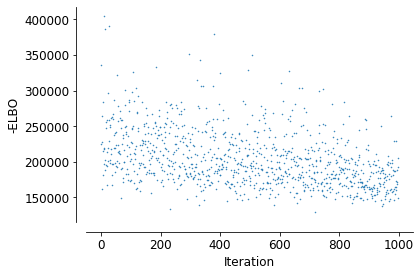

In [24]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
plt.plot(approx.hist, '.',ms=1, rasterized=True)
#ax = fig.add_subplot(111)

#ax.semilogy(approx.hist, '-', ms=1, rasterized=True)
sns.despine(offset=10)
#plt.yscale('log')
plt.ylabel('-ELBO')
plt.xlabel('Iteration')
plt.tight_layout()

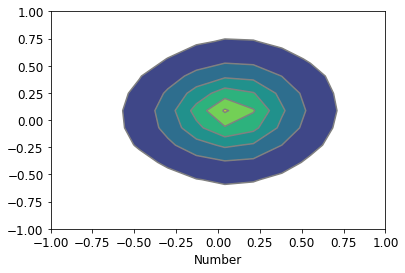

In [25]:
with pymc_model:
    plt.figure()
    trace = approx.sample(1000)
    ax = az.plot_kde(trace['chi_ss'][:,0],trace['chi_ss'][:,1])
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel('Number')
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9150b1d150>],
      dtype=object)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132 UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


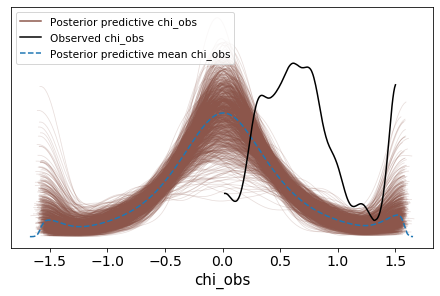

In [26]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pymc_model))

In [27]:
def plot_hpd(ax, real, ppc, error=True, ms=3, alpha=0.5, color='b'):
    if error:
        ax.plot(np.vstack([real.values.flatten(), real.values.flatten()]),
                pm.hpd(ppc).reshape(-1, 2).T, color=color, lw=1, alpha=0.05, zorder=0)
    ax.plot(real, np.median(ppc, 0), '.', ms=ms, color=color, alpha=alpha, zorder=0)

/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338 UserWarning: hpd will be deprecated Please replace hdi
/usr/local/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:146 UserWarning: More chains (1000) than draws (23). Passed array should have shape (chains, draws, *shape)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4 MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338 UserWarning: hpd will be deprecated Please replace hdi
/usr/local/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:146 UserWarning: More chains (1000) than draws (23). Passed array should have shape (chains, draws, *shape)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4 MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


Text(0, 0.5, 'Frequency')

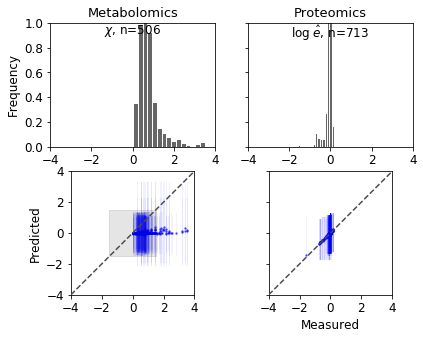

In [28]:
plt.rcParams["axes.axisbelow"] = False

fig, ax_matrix = plt.subplots(ncols=2, nrows=2, figsize=(6.5, 5),
                              sharex='row', sharey='row')

for ax in ax_matrix[1,:].flatten():
    ax.set_aspect('equal')

_ = ax_matrix[0,0].hist(xn.values.flatten(), bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
#_ = ax_matrix[0,1].hist(np.log(np.clip(vn.values.flatten(), 1E-8, 1E8)), bins=15, lw=1,
#                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,1].hist(np.log(en.values.flatten()), bins=15, lw=1, edgecolor='w',
                        density=True, facecolor='.4')

plot_hpd(ax_matrix[1,0], xn,
         trace['chi_ss'][:, :, x_inds])
#plot_hpd(ax_matrix[1,1], np.log(vn),
#         np.log(np.clip(trace['vn_ss'][:, :, v_inds], 1E-8, 1E8)))
plot_hpd(ax_matrix[1,1], np.log(en),
         trace['log_en_t'][:, :, e_inds])

for ax in ax_matrix[1,:]:
    ax.set_rasterization_zorder(1)

ax_matrix[1,0].set_xlim([-4, 4])
#ax_matrix[1,1].set_xlim([-4, 4])
ax_matrix[1,1].set_xlim([-4, 4])
ax_matrix[1,0].set_ylim([-4, 4])
#ax_matrix[1,1].set_ylim([-4, 4])
ax_matrix[1,1].set_ylim([-4, 4])

for ax in ax_matrix[0,:]:
    ax.set_xlim([-4, 4])
    ax.set_xticks([-4, -2, 0, 2, 4])

for ax in ax_matrix[1,:]:
    ax.plot([-4, 4], [-4, 4], '--', color='.3', zorder=4, lw=1.5)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-4, -2, 0, 2, 4])
    
    
ax_matrix[1,0].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5],
                            zorder=4, color='k', alpha=.1)
#ax_matrix[1,1].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5],
#                            zorder=4, color='k', alpha=.1)

ax_matrix[0, 0].set_ylim([0, 1.])

ax_matrix[0,0].set_title('Metabolomics', fontsize=13)
#ax_matrix[0,1].set_title('Fluxomics', fontsize=13)
ax_matrix[0,1].set_title('Proteomics', fontsize=13)


ax_matrix[0,0].text(0.5, 1., '$\chi$, n={}'.format(xn.shape[0] * xn.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,0].transAxes)
#ax_matrix[0,1].text(0.5, 1., '$\log\; \hat{v}$, n='+ str(vn.shape[0] * vn.shape[1]),
#                    ha='center', va='top', transform=ax_matrix[0,1].transAxes)
ax_matrix[0,1].text(0.5, 1., '$\log\; \hat{e}$, n=' + str(en.shape[0] * en.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,1].transAxes)

ax_matrix[0,1].set_xlabel('Measured')
ax_matrix[-1,1].set_xlabel('Measured')
ax_matrix[1,0].set_ylabel('Predicted')
ax_matrix[0,0].set_ylabel('Frequency')

#sns.despine(offset=2.5, trim=True)
# plt.tight_layout()

# plt.savefig('hackett_posterior_and_dists.svg', dpi=300)

In [29]:
output_flux = 'ITACON'
v_ind = model.reactions.index(output_flux)
fcc = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=trace['Ex'][i])[v_ind]
                             for i in range(len(trace))]),
                   columns=[r.id for r in model.reactions])

fcc_prior = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=trace_prior['Ex'][i])[v_ind]
                                   for i in range(len(trace_prior))]),
                         columns=[r.id for r in model.reactions])

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hpd = pm.hpd(fcc.values)
fcc_consistent = np.sign(hpd[:, 0]) == np.sign(hpd[:, 1])

/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338 UserWarning: hpd will be deprecated Please replace hdi
/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:486 FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


In [ ]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)

for i, (name, col) in enumerate(fcc.iteritems()):
    if name in fcc.columns[fcc_consistent]:
        color='g'
        print(name)
        l_g = ax.plot([i, i], az.hdi(col.to_numpy()), color=color)
        dot_g = ax.plot(i, col.median(), '.', color=color, ms=10)

    else:
        color='.4'
    
        l_4 = ax.plot([i, i], az.hdi(col.to_numpy()), color=color)
        dot_4 = ax.plot(i, col.median(), '.', color=color, ms=10)
    
    l_p = ax.plot([i, i], az.hdi(fcc_prior[name].to_numpy()), color='.8', zorder=0)
    
    
ax.axhline(0, ls='--', color='.8', zorder=0)

#ax.set_ylim([-5E-5, 1E-4])
# ax.set_xlim([-1, 16])

plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_ylabel('Flux control coefficient\n(itaconate out)')

ax.set_xlabel('Reaction')

plt.legend(((l_4[0], dot_4[0]), l_p[0], (l_g[0], dot_g[0])),
           ('Posterior\n(Overlaps zero)',  'Prior', 'Posterior\n(Consistent)',),
           borderaxespad=0, borderpad=0, ncol=2, fontsize='medium')


xs = np.where(fcc_consistent)[0]
ys = fcc.loc[:, fcc_consistent].mean(0).values
labels = fcc.columns[fcc_consistent]

plt.ylim([-.6, .6])
plt.xlim([-1, ll.nr])

#ax.set_xticks([0, 10, 20, 30, 40, 45])

plt.tight_layout()

sns.despine(trim=False, offset=10)
plt.savefig('fccs_contador.svg', transparent=True)

In [30]:
# Calc Fccs with two methods
from tqdm import tqdm
ll_link = emll.LinLogLinkMatrix(ll.N, ll.Ex, ll.Ey, ll.v_star)
fccs = np.array([ll.flux_control_coefficient(Ex=ex) for ex in tqdm(trace['Ex'])])
fccs_link = np.array([ll_link.flux_control_coefficient(Ex=ex) for ex in tqdm(trace['Ex'])])

100%|██████████| 1000/1000 [00:00<00:00, 1306.17it/s]


In [31]:
fccs.shape

(1000, 67, 67)

In [32]:
r_med = np.median(fccs, 0).flatten()
l_med = np.median(fccs_link, 0).flatten()
r_err = [r_med - np.percentile(fccs, 25, axis=0).flatten(),
         np.percentile(fccs, 75, axis=0).flatten() - r_med]
l_err = [l_med - np.percentile(fccs_link, 25, axis=0).flatten(),
         np.percentile(fccs_link, 75, axis=0).flatten() - l_med]

Text(1, -1, '$\\rho = 1.00$')

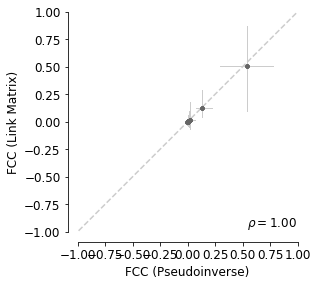

In [33]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

ax.set_aspect('equal')
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            marker='.', color='.4', zorder=3, alpha=0.5)
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            elinewidth=.5, color='.8', alpha=0.5, zorder=2)

ax.plot([-5, 5], [-5, 5], '--', color='.8', zorder=0)

ax.set_xlabel('FCC (Pseudoinverse)')
ax.set_ylabel('FCC (Link Matrix)')

ax.set_rasterization_zorder(4)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])


plt.tight_layout()
sns.despine(trim=True, offset=10)
ax.text(1, -1, '$\\rho = {:.2f}$'.format(
    pd.Series(r_med).corr(pd.Series(l_med))), ha='right', va='bottom', fontsize=12)

# plt.savefig('fcc_comparison.svg', dpi=300)

In [34]:
fcc_med = np.median(fccs,0)
r_labels = [r.id for r in model.reactions]
fcc_med = pd.DataFrame(fcc_med, columns=r_labels, index=r_labels)

In [35]:
def corrwith(left, right, df=True):
    # demeaned data
    left_tiled = np.repeat(left.values[:, np.newaxis, :], right.shape[0], 1)
    right_tiled = np.repeat(right.values[np.newaxis, :, :], left.shape[0], 0)

    ldem = left_tiled - left_tiled.mean(-1)[:, :, np.newaxis]
    rdem = right_tiled - right_tiled.mean(-1)[:, :, np.newaxis]

    num = (ldem * rdem).sum(-1)

    dom = (left.shape[1] - 1) * left_tiled.std(-1) * right_tiled.std(-1)
    correl = num / dom
    
    if not df:
        return correl
    else: 
        return pd.DataFrame(correl, index=left.index, columns=right.index)

corr_df = corrwith(e, v).T

In [36]:
def random_corr_iterator():
    return corrwith(e.loc[:, np.random.permutation(e.columns)],
                    v.loc[:, np.random.permutation(e.columns)], df=False)

In [37]:
permutated_corr_mat = np.array([random_corr_iterator() for _ in tqdm(range(2000))])

100%|██████████| 2000/2000 [00:02<00:00, 832.82it/s]


In [38]:
import scipy
from scipy import cluster

In [39]:
z_scores = (corr_df - permutated_corr_mat.mean(0).T) / permutated_corr_mat.std(0).T
p_vals = 2 * z_scores.abs().apply(scipy.stats.norm.sf)

In [40]:
def sort_df(df):
    sort_x = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df, "complete"))
    sort_y = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df.T, "complete"))
    
    return df.iloc[sort_x, sort_y]

In [41]:
fccs_hpd = az.hdi(fccs)
fcc_consistent = np.sign(fccs_hpd[:,0]) == np.sign(fccs_hpd[:,1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, index=r_labels)

/usr/local/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:146 UserWarning: More chains (1000) than draws (67). Passed array should have shape (chains, draws, *shape)


In [42]:
sorted_corr_df = sort_df(corr_df)

In [43]:
fcc_med_measured = fcc_med.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)

In [44]:
fcc_consistent_measured = fcc_consistent_df.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)

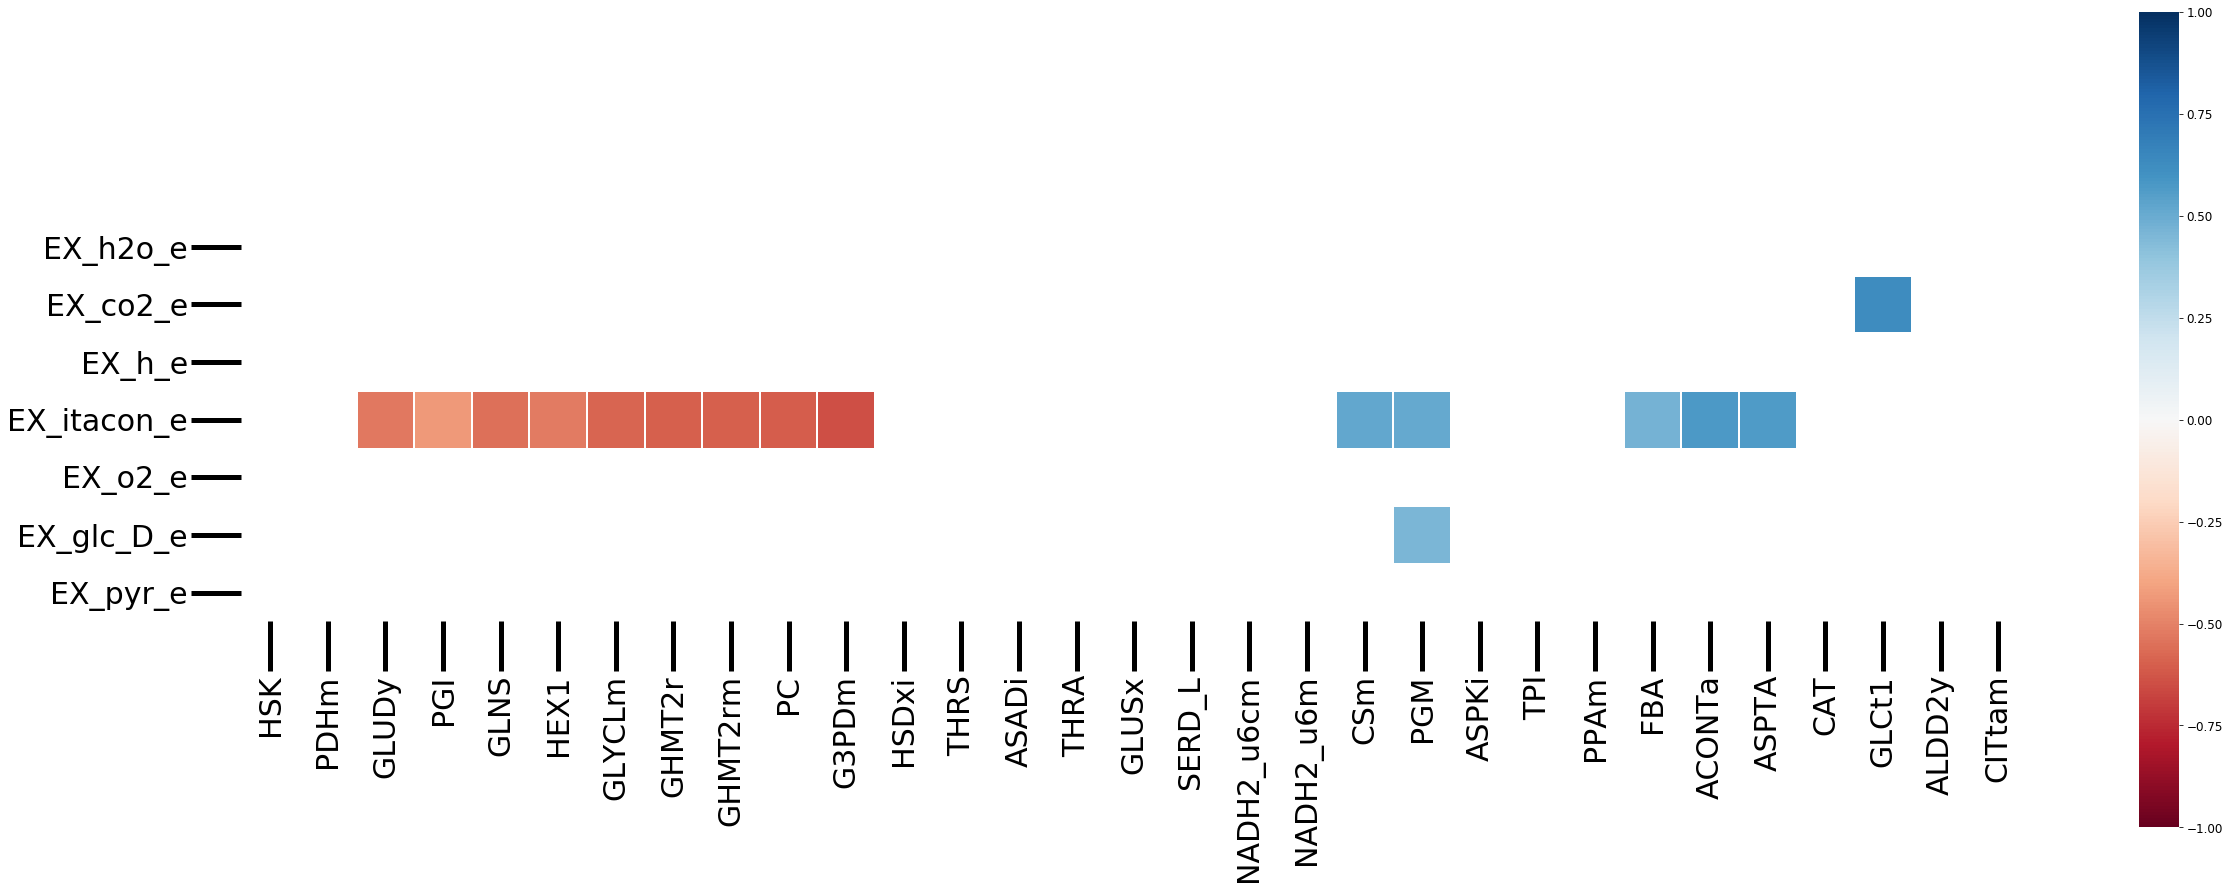

In [45]:
#plt.rcParams.update({'font.size': 50})

with sns.plotting_context('notebook'):
    fig = plt.figure(figsize=(40,15))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')
    
sns.heatmap(sorted_corr_df[p_vals < 0.05].values, vmin=-1, vmax=1,
            cmap='RdBu', cbar=True, rasterized=True, lw=1)

ax. tick_params( axis='both', length = 50, width = 5)
_=ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_=ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_=ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_=ax.set_xticklabels(sorted_corr_df.columns,rotation = 90)

for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(30)

#plt.savefig('Correlation.png', dpi=500)

IndexError: cannot do a non-empty take from an empty axes.

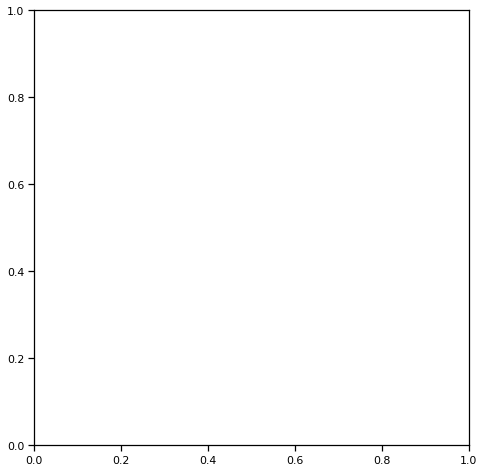

In [46]:
with sns.plotting_context('notebook'):
    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')
    
sns.heatmap(fcc_med_measured[fcc_consistent_measured].values,
           center=0, robust=True, cmap='RdBu', cbar=True, rasterized=True, lw=1)


_=ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_=ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_=ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_=ax.set_xticklabels(sorted_corr_df.columns,rotation = 45)


In [47]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [48]:
import scipy
from scipy import cluster

In [49]:
e_unmeasured_hpd = az.hdi(trace['log_e_unmeasured'])
e_consistent = np.sign(e_unmeasured_hpd[:,0]) == np.sign(e_unmeasured_hpd[:,1])

/usr/local/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:146 UserWarning: More chains (1000) than draws (23). Passed array should have shape (chains, draws, *shape)


In [50]:
capacity_hpd = az.hdi(trace['ex_capacity_entries'])

/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:486 FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


In [51]:
capacity_consistent = np.sign(capacity_hpd[:,0]) == np.sign(capacity_hpd[:,1])

In [52]:
capacity_consistent.sum()

0

In [53]:
capacity_consistent.sum()/len(capacity_consistent)

0.0

In [54]:
e_laplace_inds

array([ 4,  6, 13, 14, 16, 18, 25, 27, 29, 37, 44, 45, 61, 64])

In [55]:
# Elasticities

e_guess = -N.T
e_flat = e_guess.flatten()
nonzero_inds = np.where(e_flat != 0)[0]
zero_inds = np.where(e_flat == 0)[0]
e_sign = np.sign(e_flat[nonzero_inds])
flat_indexer = np.hstack([nonzero_inds, zero_inds]).argsort()

In [56]:
identifiable_elasticities = (np.diff(az.hdi(trace['ex_kinetic_entries'])) < .75).flatten()

mlabels = [m.id for m in model.metabolites]
rlabels = [r.id for r in model.reactions]

e_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                     for mlabel in mlabels] for rlabel in rlabels]).flatten()

elast_nonzero = pd.DataFrame((trace['ex_kinetic_entries'] * e_sign)[:, identifiable_elasticities],
                            columns=e_labels[nonzero_inds][identifiable_elasticities])

In [57]:
null = pd.DataFrame(az.hdi(trace['ex_capacity_entries']))
sig = np.sign(null)[0] == np.sign(null)[1]
sum(sig)

0

In [58]:
elast_zero = pd.DataFrame(trace['ex_capacity_entries'][:, sig], columns=e_labels[zero_inds[sig]])
elast_posterior = elast_nonzero.iloc[:, elast_nonzero.mean().argsort()].join(elast_zero)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5174 but corresponding boolean dimension is 2390

In [59]:
elast_prior = pd.DataFrame(
    trace_prior['Ex'].reshape(500, -1), columns=e_labels
).reindex(columns=elast_posterior.columns)

ValueError: cannot reshape array of size 1085400 into shape (500,newaxis)

NameError: name 'elast_posterior' is not defined

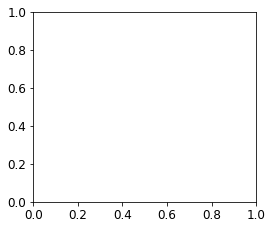

In [60]:
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)

_ = sns.boxplot(data=elast_posterior, fliersize=0, ax=ax, zorder=2)
_ = sns.boxplot(data=elast_prior, fliersize=0, zorder=0, showmeans=False,
                 capprops=dict(color='.9', zorder=0), medianprops=dict(color='.9', zorder=0.5),
                 whiskerprops=dict(color='.9', zorder=0), boxprops=dict(color='.9', facecolor='w', zorder=0), ax=ax)


_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(0, ls='--', color='.5', zorder=1)
ax.axvline(elast_nonzero.shape[1] - .5, color='.5', ls='--')

ax.set_ylabel('Elasticity')
sns.despine(trim=True)

ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
ax.set_ylim([-3, 3])


ax.set_xlim(-.75, elast_nonzero.shape[1] + elast_zero.shape[1] - .5)
sns.despine(ax=ax, trim=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.tight_layout()

In [61]:
output_flux = 'ITACON'
v_ind = model.reactions.index(output_flux)
fcc = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[v_ind]
                             for ex in trace['Ex']]),
                   columns=[r.id for r in model.reactions])

fcc_prior = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[v_ind]
                                   for ex in trace_prior['Ex']]),
                         columns=[r.id for r in model.reactions])

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hpd = pm.hpd(fcc.values)
fcc_consistent = np.sign(hpd[:, 0]) == np.sign(hpd[:, 1])

/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338 UserWarning: hpd will be deprecated Please replace hdi
/usr/local/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:486 FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


In [62]:
fcc_posterior = pd.DataFrame({'posterior_mean':fcc.mean(axis=0), 
                      'posterior_ymax':fcc.mean(axis=0) + fcc.std(axis=0),
                      'posterior_ymin':fcc.mean(axis=0) - fcc.std(axis=0),
                             'posterior':'posterior'}).reset_index()
fcc_prior_df = pd.DataFrame({'prior_mean': fcc_prior.mean(axis=0),
                      'prior_ymax': fcc_prior.mean(axis=0) + fcc_prior.std(axis=0),
                      'prior_ymin': fcc_prior.mean(axis=0) - fcc_prior.std(axis=0),
                         'prior': ' prior'},
                      ).reset_index()
fcc_df = pd.DataFrame({ 'index': fcc_prior_df['index'].append(fcc_posterior['index'], ignore_index=True),
                     'mean': fcc_prior_df.prior_mean.append( fcc_posterior.posterior_mean, ignore_index=True),
                     'ymax': fcc_prior_df.prior_ymax.append( fcc_posterior.posterior_ymax, ignore_index=True),
                     'ymin': fcc_prior_df.prior_ymin.append( fcc_posterior.posterior_ymin, ignore_index=True),
                     'Legend': fcc_prior_df.prior.append(fcc_posterior.posterior, ignore_index=True)})
fcc_posterior[fcc_posterior['posterior_mean'] > 0.1]

,index,posterior_mean,posterior_ymax,posterior_ymin,posterior
21,EX_glc_D_e,0.522733,0.802363,0.243103,posterior
47,GLCt1,0.158797,0.280902,0.036692,posterior


ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not Series

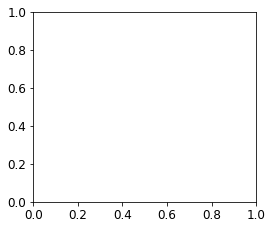

In [63]:
fig = plt.figure(figsize=(4,3.5))
ax = fig.add_subplot(111)

for i , (name,col) in enumerate(fcc.iteritems()):
    
    if name in fcc.columns[fcc_consistent]:
        color='g'
        
        l_g = ax.plot([i,i], pm.hpd(col), color=color)
        dot_g = ax.plot(i, col.median(), '.', color=color, ms=10)
        
    else:
        color = '.4'
        
        l_4 = ax.plot([i,i], az.hdi(col), color=color)
        dot_4 = ax.plot(i, col.median(), '.', color=color, ms=10)
    
    l_p = ax.plot([i, i], pm.hpd(fcc_prior[name]), color='.8', zorder=0)
    

ax.axhline(0, ls='--', color='.8', zorder=0)

plot.ticklabel_format(axis='y',style='sci', scilimits=(-2,2))
ax.set_ylabel('Flux control coefficients\n(itaconate out)')

ax.set_xlabel('Reaction')

plt.legend(((l_4[0], dot_4[0]), l_p[0], (l_g[0], dot_g[0])),
          ('Posterior\n(Overlaps zero)', 'Prior', 'Posterior\n(Consistent)',),
          borderaxespad=0, border=0, ncol=2, fontsize='medium')

xs = np.where(fcc_consistent)[0]
ys = fcc.loc[:, fcc_consistent].mean(0).values
labels = fcc.columns[fcc_consistent]

plt.ylim([-.6, .6])
plt.xlim([-1, ll.nr])

plt.tight_layout()

sns.despine(trim=False, offset=10)


/usr/local/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FCC_ggplot_glycolysis_itaconate.png


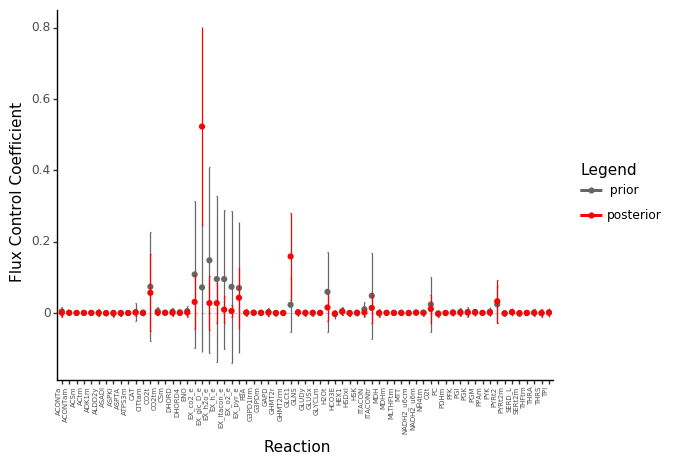

<ggplot: (8768764714249)>

In [64]:
from plotnine import ggplot, aes, geom_point, geom_errorbar, element_text, theme, theme_bw, theme_classic, labs, scale_color_manual, geom_hline, ggsave
g = (ggplot(mapping=aes(x='index', 
                        y='mean', 
                        color='Legend'), 
            data=fcc_df)
    + geom_hline(aes(yintercept=0), 
                 linetype='dashed', 
                 color='0.8')
    + geom_point()
    + geom_errorbar(aes(x='index', 
                        ymin='ymin', 
                        ymax='ymax', 
                        color='Legend'),
                    width=0.1)
    + labs(x='Reaction', 
           y='Flux Control Coefficient')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=90, size=5,
                                     hjust=1))
    + scale_color_manual(values=[".4", "r"]))

ggsave(g,'FCC_ggplot_glycolysis_itaconate.png')
g